Clone Dataset from GitHub

In [ ]:
!git clone https://github.com/fruits-360/fruits-360-100x100.git


Cloning into 'fruits-360-100x100'...
remote: Enumerating objects: 141164, done.
remote: Counting objects: 100% (7024/7024), done.
remote: Compressing objects: 100% (6998/6998), done.
remote: Total 141164 (delta 38), reused 7011 (delta 26), pack-reused 134140 (from 3)
Receiving objects: 100% (141164/141164), 1018.33 MiB | 31.29 MiB/s, done.
Resolving deltas: 100% (241/241), done.
Updating files: 100% (139322/139322), done.


In [ ]:
#List folders
!ls fruits-360-100x100

LICENSE  README.md  Test  Training


In [ ]:
import os

# Paths to the dataset (adjust if folder name differs after cloning)
train_dir = "/content/fruits-360-100x100/Training"
test_dir = "/content/fruits-360-100x100/Test"

# Get class names
class_names = sorted(os.listdir(train_dir))
num_classes = len(class_names)

print(f"Number of classes: {num_classes}")
print("Example classes:", class_names[:10])


Number of classes: 207
Example classes: ['Apple 10', 'Apple 11', 'Apple 12', 'Apple 13', 'Apple 14', 'Apple 17', 'Apple 18', 'Apple 19', 'Apple 5', 'Apple 6']


**EDA**



In [ ]:
import pandas as pd

train_counts = {cls: len(os.listdir(os.path.join(train_dir, cls))) for cls in class_names}
test_counts = {cls: len(os.listdir(os.path.join(test_dir, cls))) for cls in class_names}

eda_df = pd.DataFrame({
    "Class": class_names,
    "Train Images": [train_counts[cls] for cls in class_names],
    "Test Images": [test_counts[cls] for cls in class_names]
})

eda_df.head()


,Class,Train Images,Test Images
0,Apple 10,699,231
1,Apple 11,430,142
2,Apple 12,466,154
3,Apple 13,699,235
4,Apple 14,466,154


<Figure size 1800x600 with 0 Axes>

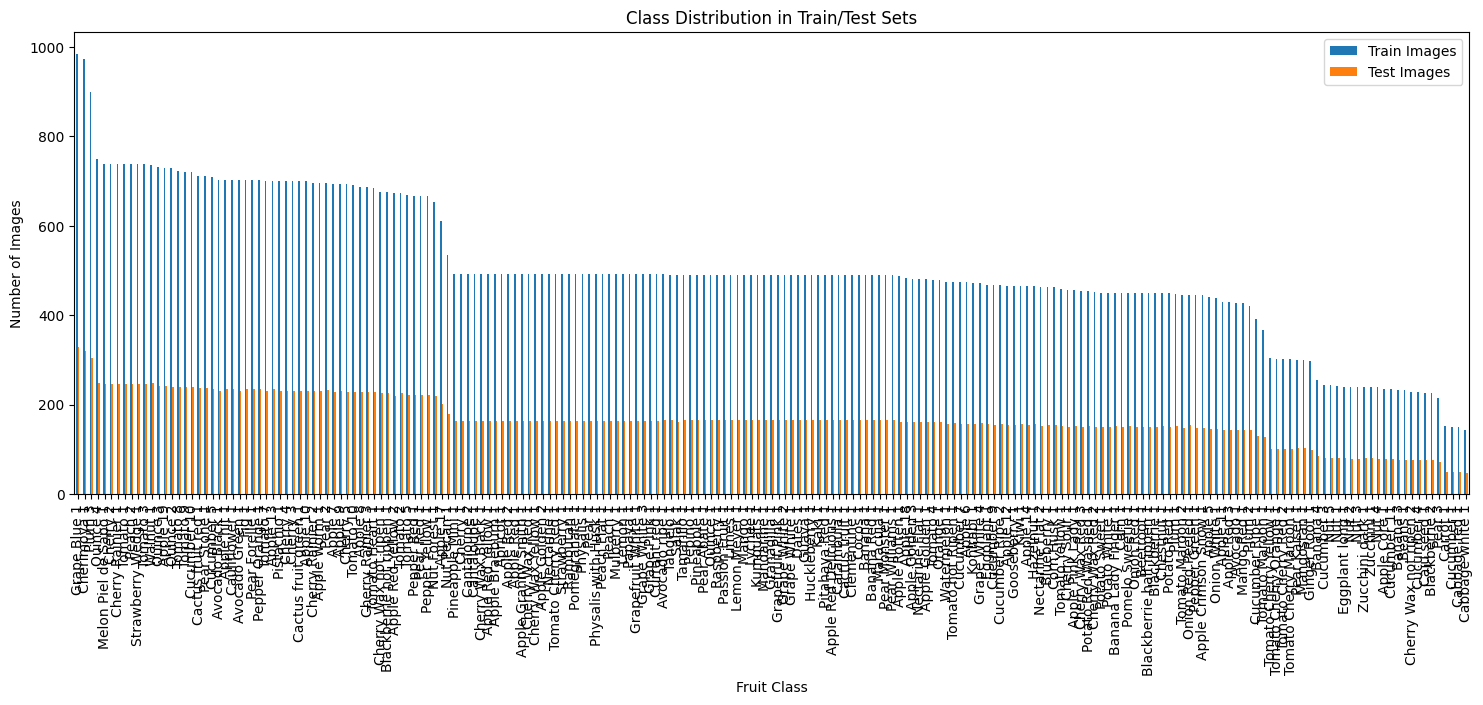

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(18,6))
eda_df.sort_values("Train Images", ascending=False).plot(
    x="Class", y=["Train Images", "Test Images"], kind="bar", figsize=(18,6)
)
plt.title("Class Distribution in Train/Test Sets")
plt.ylabel("Number of Images")
plt.xlabel("Fruit Class")
plt.xticks(rotation=90)
plt.show()


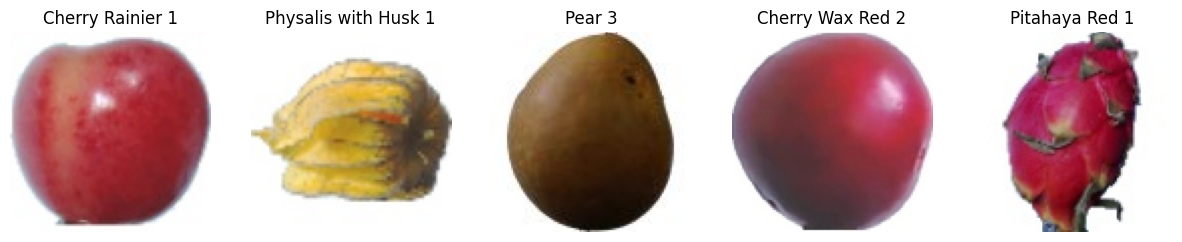

In [ ]:
import random
import matplotlib.image as mpimg

sample_classes = random.sample(class_names, 5)  # Pick 5 random classes
plt.figure(figsize=(15, 5))

for i, cls in enumerate(sample_classes):
    img_name = random.choice(os.listdir(os.path.join(train_dir, cls)))
    img_path = os.path.join(train_dir, cls, img_name)
    img = mpimg.imread(img_path)
    plt.subplot(1, 5, i+1)
    plt.imshow(img)
    plt.title(cls)
    plt.axis("off")

plt.show()


**Data preprocessing & augmentation**

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Training data generator with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Testing data generator (no augmentation)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(100, 100),
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(100, 100),
    batch_size=32,
    class_mode='categorical'
)


Found 104456 images belonging to 207 classes.
Found 34864 images belonging to 207 classes.


Implements three transfer learning models:

EfficientNetB0

ResNet50

DenseNet121

**build three tranfer learning models**

In [ ]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import EfficientNetB0, ResNet50, DenseNet121

def build_and_train_model(base_model_class, input_shape=(100, 100, 3), num_classes=131, model_name="Model"):
    print(f"\n==== Training {model_name} ====")

    # Load base model without top layer
    base_model = base_model_class(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False  # Freeze base model

    # Add custom layers
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dropout(0.3)(x)
    output = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=output)

    # Compile
    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

    # Callbacks
    early_stop = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)

    # Train
    history = model.fit(
        train_generator,
        validation_data=test_generator,
        epochs=3,
        callbacks=[early_stop],
        verbose=1
    )

    # Evaluate
    loss, acc = model.evaluate(test_generator, verbose=0)
    print(f"{model_name} Test Accuracy: {acc:.4f}")

    return model, acc, history


**train each model with 5 epochs**

In [ ]:
# Number of classes from our generator
num_classes = train_generator.num_classes

# Train EfficientNetB0
efficientnet_model, efficientnet_acc, efficientnet_history = build_and_train_model(
    EfficientNetB0, num_classes=num_classes, model_name="EfficientNetB0"
)

# Train ResNet50
resnet_model, resnet_acc, resnet_history = build_and_train_model(
    ResNet50, num_classes=num_classes, model_name="ResNet50"
)

# Train DenseNet121
densenet_model, densenet_acc, densenet_history = build_and_train_model(
    DenseNet121, num_classes=num_classes, model_name="DenseNet121"
)



==== Training EfficientNetB0 ====
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/3


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


3265/3265 ━━━━━━━━━━━━━━━━━━━━ 393s 114ms/step - accuracy: 0.0062 - loss: 5.4494 - val_accuracy: 0.0069 - val_loss: 5.3887
Epoch 2/3
3265/3265 ━━━━━━━━━━━━━━━━━━━━ 350s 107ms/step - accuracy: 0.0065 - loss: 5.4409 - val_accuracy: 0.0071 - val_loss: 5.4062
Epoch 3/3
3265/3265 ━━━━━━━━━━━━━━━━━━━━ 379s 106ms/step - accuracy: 0.0069 - loss: 5.4419 - val_accuracy: 0.0066 - val_loss: 5.4031
EfficientNetB0 Test Accuracy: 0.0071

==== Training ResNet50 ====
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/3
3265/3265 ━━━━━━━━━━━━━━━━━━━━ 407s 121ms/step - accuracy: 0.0162 - loss: 5.3009 - val_accuracy: 0.0563 - val_loss: 4.5359
Epoch 2/3
3265/3265 ━━━━━━━━━━━━━━━━━━━━ 379s 116ms/step - accuracy: 0.0416 - loss: 4.7925 - val_accuracy: 0.1072 - val_loss: 4.2295
Epoch 3/3
3265/3265 ━━━━━━━━━━━━━━━━━━━━ 381s 117ms/step - accuracy: 0.0542 - loss: 4.6214 - val_accuracy: 0.1178 - val_loss: 4.1219
ResNet50 Test Accuracy: 0.1178

==== Training DenseNet121 ====
29084464/29084464 ━━━━━━━━━━━━━━

**compare models' results**

In [ ]:
import pandas as pd

results_df = pd.DataFrame({
    "Model": ["EfficientNetB0", "ResNet50", "DenseNet121"],
    "Test Accuracy": [efficientnet_acc, resnet_acc, densenet_acc]
})

print(results_df)


            Model  Test Accuracy
0  EfficientNetB0       0.007056
1        ResNet50       0.117772
2     DenseNet121       0.943179


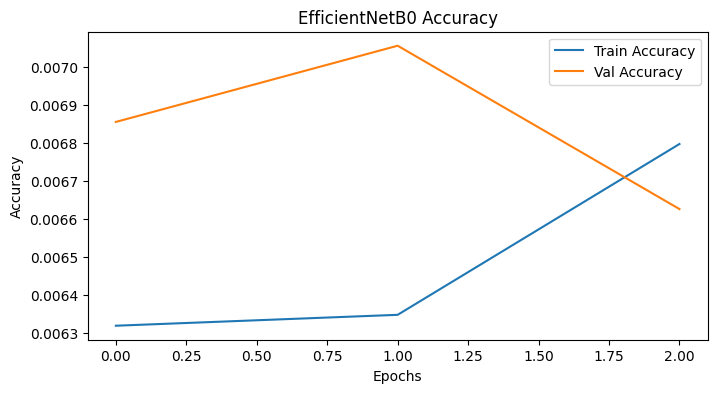

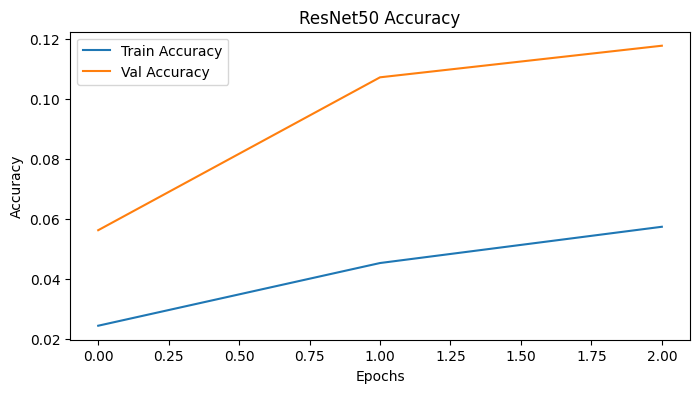

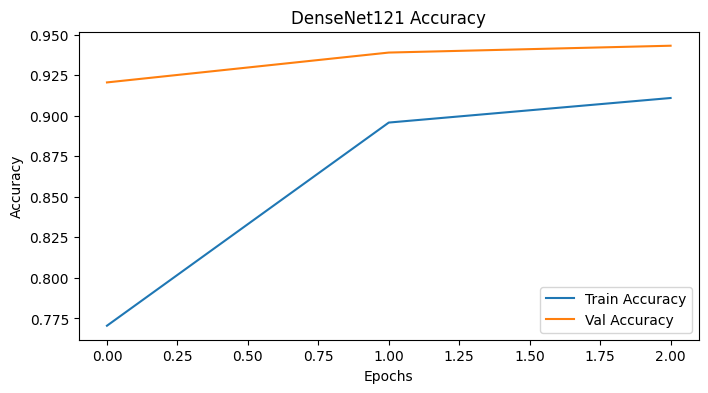

In [ ]:
def plot_history(history, model_name):
    plt.figure(figsize=(8,4))
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title(f"{model_name} Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

plot_history(efficientnet_history, "EfficientNetB0")
plot_history(resnet_history, "ResNet50")
plot_history(densenet_history, "DenseNet121")
